# Create Real World Test Data

In [1]:
import pandas as pd
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
from mpl_toolkits.basemap import Basemap
from scipy.signal import detrend

import matplotlib.pyplot as plt
import time
import datetime

In [2]:
import os
os.chdir("/Users/kristianolsson/Desktop/DS6013_CC")

## SST data

https://psl.noaa.gov/data/gridded/data.cobe2.html

Use data from 1950 to present.

Interpolate observations to the grid used in the CESM. 

Then focus only on Jul-Oct. 

Then detrend.

In [3]:
sst_data = xr.open_dataset('sst.mon.mean.nc', decode_times=True)
sst_data

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 2090)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2024-02-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    title:            created 12/2013 from data provided by JRA
    history:          Created 12/2012 from data obtained from JRA by ESRL/PSD
    platform:         Analyses
    citation:         Hirahara, S., Ishii, M., and Y. Fukuda,2014: Centennial...
    institution:      NOAA ESRL/PSD
    Conventions:      CF-1.2
    dataset_title:    COBE-SST2 Sea Surface Temperature and Ice
    original_source:  https://climate.mri-jma.go.jp/pub/ocean/cobe-sst2/
    References:       http://www.psl.noaa.gov/data/gridded/cobe2.html

In [4]:
ds2 = xr.open_dataset("Detrended_SST.nc", decode_times=False)
ds2

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 7400)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 0 366 731 1096 1461 ... 25203 25568 25933 26298 26664
Data variables:
    SST      (time, lat, lon) float32 ...

In [5]:
# Interpolate data to match train/val/test coordinates
sst_interpolated_data = sst_data['sst'].interp(lat=ds2.lat.values, lon=ds2.lon.values)

sst_interpolated = xr.Dataset(
    {
        "SST": (("time", "lat", "lon"), sst_interpolated_data.data)
    },
    coords={
        "time": sst_interpolated_data.time,
        "lat": sst_interpolated_data.lat,
        "lon": sst_interpolated_data.lon
    }
)

sst_interpolated

<xarray.Dataset>
Dimensions:  (time: 2090, lat: 192, lon: 288)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2024-02-01
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    SST      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

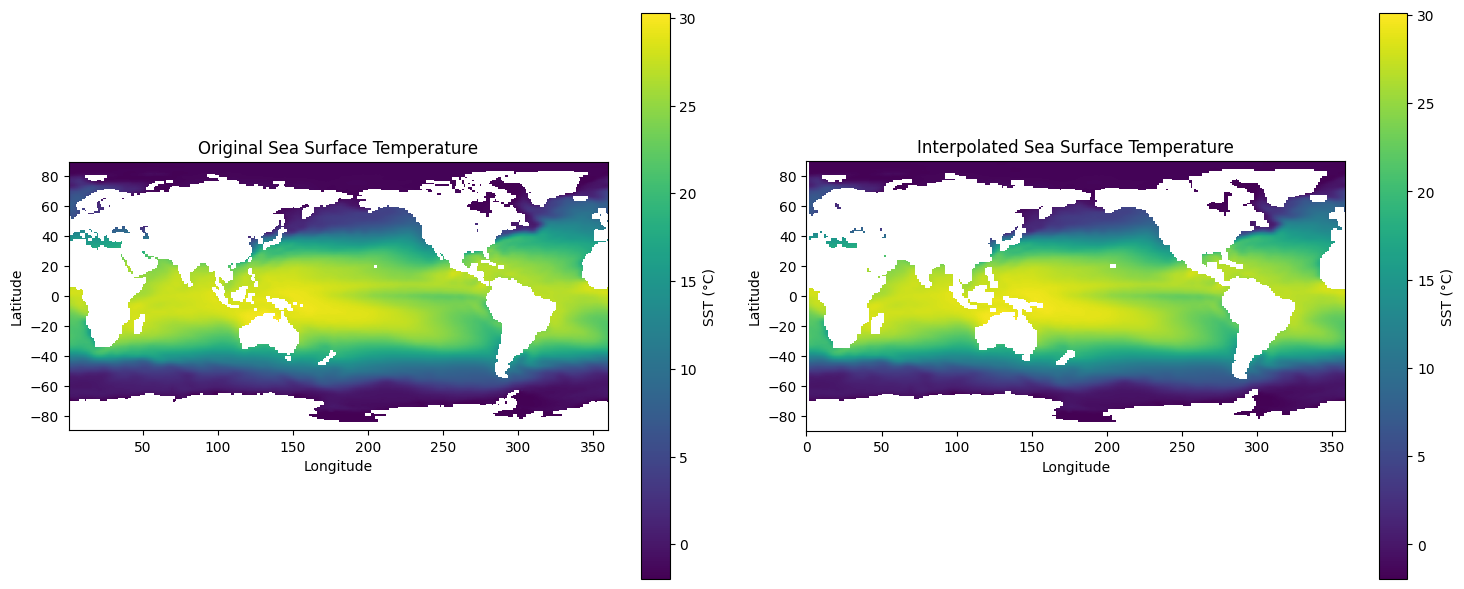

In [6]:
# Interpolation plots
plt.figure(figsize=(15, 6))

lat = sst_data.coords['lat']
lon = sst_data.coords['lon']
plt.subplot(1, 2, 1)
plt.imshow(sst_data.sst[0], extent=[lon.min(), lon.max(), lat.min(), lat.max()], origin='upper')
plt.colorbar(label='SST (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Original Sea Surface Temperature')

lat = sst_interpolated.coords['lat']
lon = sst_interpolated.coords['lon']
plt.subplot(1, 2, 2)
plt.imshow(sst_interpolated.SST[0], extent=[lon.min(), lon.max(), lat.min(), lat.max()], origin='lower')
plt.colorbar(label='SST (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Interpolated Sea Surface Temperature')

plt.tight_layout()
plt.show()

In [7]:
# Celsius to Kelvin
sst_interpolated['SST'] += 273.15

# Select Jul-Oct
sst_df = sst_interpolated.sel(time=sst_interpolated['time.month'].isin([7, 8, 9, 10])).resample(time='AS').mean()

# Select data from 1950 onwards
mask = (sst_df['time'].dt.year >= 1950) & (sst_df['time'].dt.year <= 2021)
sst_df = sst_df.sel(time=mask)

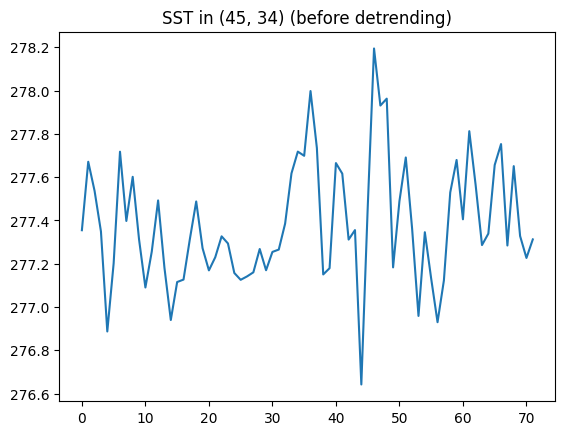

In [8]:
# Sanity Plot (before detrending)
plt.title('SST in (45, 34) (before detrending)')
plt.plot(sst_df.SST[:, 45, 34].values)

In [9]:
# Detrend SST
sst_detrended = sst_df.copy(deep=True) 
sst_detrended = sst_detrended.fillna(0)

for j in range(len(sst_detrended['lat'].values)):
    for i in range(len(sst_detrended['lon'].values)):
        lat_lon_array = sst_detrended.SST[:, j, i].values
        if np.mean(lat_lon_array) == 0:
            continue
        sst_detrended.SST[:, j, i] = detrend(lat_lon_array)

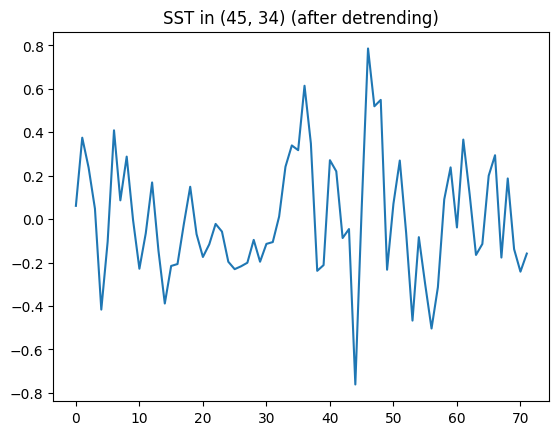

In [10]:
# Sanity Plot (after detrending)
plt.title('SST in (45, 34) (after detrending)')
plt.plot(sst_detrended.SST[:, 45, 34].values)

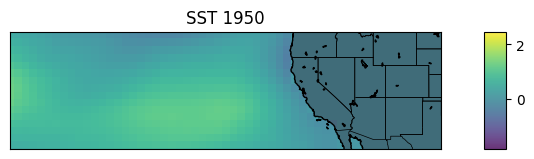

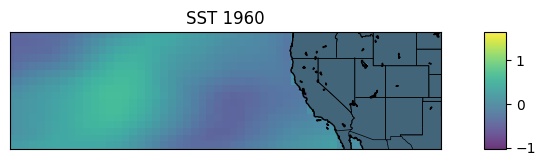

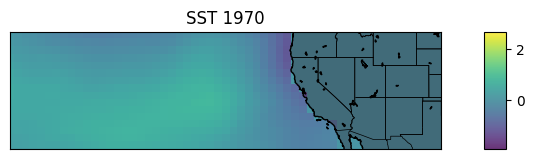

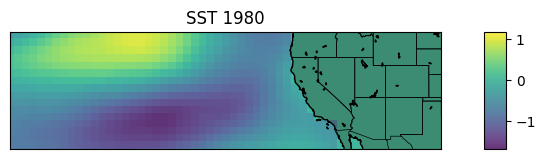

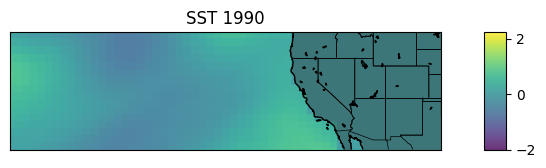

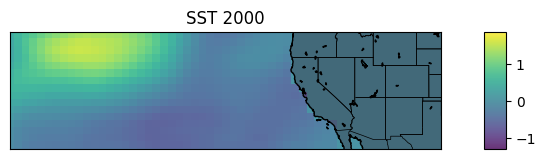

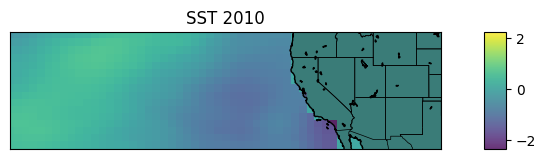

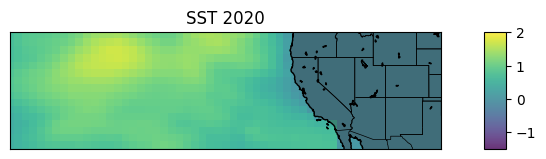

In [11]:
lons = sst_detrended['lon'].values
lats = sst_detrended['lat'].values

for i in range(0,80,10):
    lon, lat = np.meshgrid(lons, lats)

    map = Basemap(projection='merc', llcrnrlon=190., llcrnrlat=30., urcrnrlon=260., urcrnrlat=45., resolution='i')
    map.drawcoastlines()
    map.drawstates()
    map.drawcountries()
    map.drawlsmask(land_color='brown', ocean_color='#CCFFFF') 
    map.drawcounties()

    x, y = map(lon, lat)
    sst_subset = sst_detrended.isel(time=i)
    year_value = pd.Timestamp(sst_subset.time.values)

    color_scheme = map.pcolormesh(x, y, np.squeeze(sst_subset.SST), alpha=.8)
    color_bar = map.colorbar(color_scheme, location='right', pad='10%')

    plt.title(f'SST {year_value.year}')
    plt.show()

In [12]:
sst_detrended.to_netcdf("real_world_sst.nc")

In [13]:
sst_detrended

<xarray.Dataset>
Dimensions:  (time: 72, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) datetime64[ns] 1950-01-01 1951-01-01 ... 2021-01-01
Data variables:
    SST      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

## Precipitation data

https://psl.noaa.gov/data/gridded/data.unified.daily.conus.html

Use data from 1950 to present.

Average over Northern, Central, Southern California only. 

Average only during Nov to Mar. 

Then detrend. 

In [14]:
prect_data = xr.open_dataset('precip.V1.0.mon.mean.nc', decode_times=True)

In [15]:
prect_data

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 300, time: 898)
Coordinates:
  * lat      (lat) float32 20.12 20.38 20.62 20.88 ... 49.12 49.38 49.62 49.88
  * lon      (lon) float32 230.1 230.4 230.6 230.9 ... 304.1 304.4 304.6 304.9
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2022-10-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    title:          CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    Conventions:    COARDS
    history:        created 05/2012 by CAS from data obtained at NOAA NCEP/CPC
    description:    CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    platform:       Observations
    Comments:       Preciptation is accumulated from 12z of previous day to 1...
    dataset_title:  CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    References:     http://www.psl.noaa.gov/data/gridded/data.unified.daily.c...

In [16]:
def process_region(data, region, lat_slice, lon_slice):
    # Weight and average for the specified region
    ds_region = data.sel(lat=lat_slice, lon=lon_slice)
    weights_region = np.cos(np.deg2rad(ds_region['lat']))
    weights_region.name = 'weights'
    ds_weighted_region = ds_region['precip'].weighted(weights_region)
    mean_sst_region = ds_weighted_region.mean(dim=['lat', 'lon'])
    ds_region = mean_sst_region

    # Filter months of interest (Nov, Dec, Jan, Feb, Mar)
    month_list = [True if month in [11, 12, 1, 2, 3] else False for month in data['time.month']]
    ds_region = ds_region.loc[{'time': month_list}] 

    # Create a new variable for grouping Nov, Dec and Jan, Feb, March from the following year
    # e.g. Nov, Dec 1940 and Jan, Feb, March 1941 -> 1940
    ds_region['year_group'] = (
        ds_region['time.year'] + (ds_region['time.month'] >= 11) - 1
    ).astype(str)

    # Calculate sum PRECT for each year
    ds_region = ds_region.groupby('year_group').sum(dim='time')

    # Append to the DataFrame
    df = pd.DataFrame({
        'year': ds_region.coords['year_group'].values,
        'region': region,
        'PRECT': ds_region.values
    })

    return df

def calc_prect(prect_df, PRECT_data_fn):
    
    # Load Dataset
    ds = xr.open_dataset(PRECT_data_fn, decode_times=True)

    # Dimension slcies for each region
    south_df = process_region(ds, 'South', slice(32.0, 34.9), slice(239.4, 245.6))
    central_df = process_region(ds, 'Central', slice(34.9, 38.6), slice(236.9, 243.1))
    north_df = process_region(ds, 'North', slice(38.8, 42.2), slice(235.6, 240.6))

    # Append the DataFrames to your main list
    prect_df = pd.concat([prect_df, north_df, central_df, south_df])
    return prect_df

In [17]:
prect_df = pd.DataFrame(columns=['year', 'region', 'PRECT'])
prect_df = calc_prect(prect_df, 'precip.V1.0.mon.mean.nc')
prect_df.shape

(225, 3)

In [18]:
prect_df = prect_df[(prect_df['year'] != '1947') & (prect_df['year'] != '1948') & (prect_df['year'] != '1949')]
prect_df.shape

(216, 3)

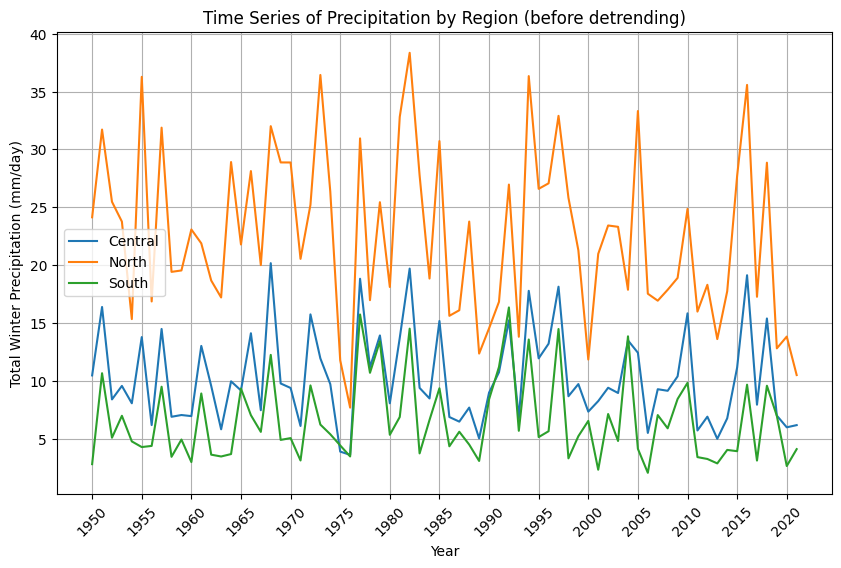

In [19]:
# Sanity Plot (before detrending)
plt.figure(figsize=(10, 6))

for region, data in prect_df.groupby('region'):
    plt.plot(data['year'], data['PRECT'], label=region)

plt.xlabel('Year')
plt.ylabel('Total Winter Precipitation (mm/day)')
plt.title('Time Series of Precipitation by Region (before detrending)')

x_ticks = data['year'][::5]
plt.xticks(ticks=x_ticks, rotation=45)
plt.legend()
plt.grid(True)

plt.show()

In [20]:
# Detrend PRECT
prect_detrended = prect_df.copy()
regions = np.array(prect_detrended["region"].unique())
years = np.array(prect_detrended["year"].unique())

for region in regions:
    subset_df = prect_detrended.loc[prect_detrended["region"] == region]
    x = years.reshape(-1,1).astype(int)
    y = subset_df.PRECT.values
    dt = detrend(y)
    prect_detrended.loc[prect_detrended["region"] == region, 'PRECT'] = dt

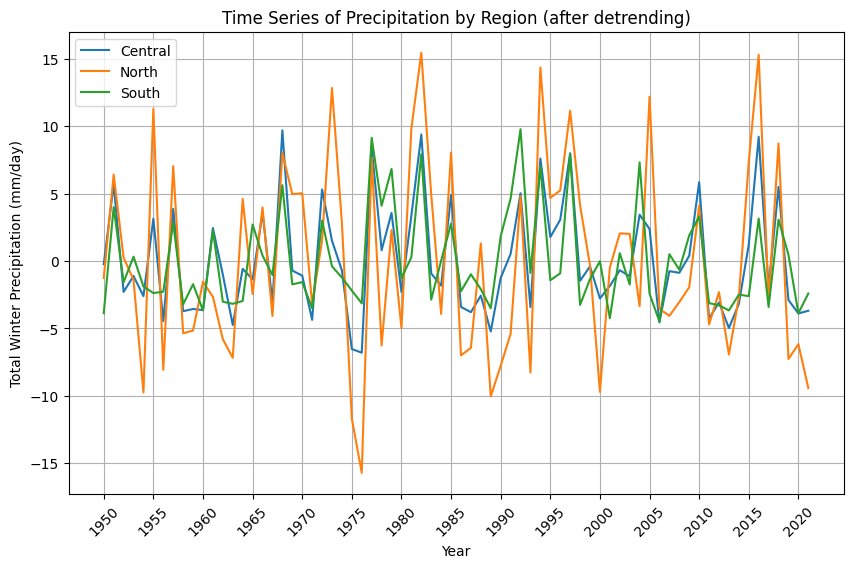

In [21]:
# Sanity Plot (after detrending)
plt.figure(figsize=(10, 6))

for region, data in prect_detrended.groupby('region'):
    plt.plot(data['year'], data['PRECT'], label=region)

plt.xlabel('Year')
plt.ylabel('Total Winter Precipitation (mm/day)')
plt.title('Time Series of Precipitation by Region (after detrending)')

x_ticks = data['year'][::5]
plt.xticks(ticks=x_ticks, rotation=45)
plt.legend()
plt.grid(True)

plt.show()

In [22]:
prect_detrended.to_csv("real_world_prect.csv")

In [23]:
prect_detrended

,year,region,PRECT
3,1950,North,-1.252478
4,1951,North,6.405958
5,1952,North,0.244133
6,1953,North,-1.394033
7,1954,North,-9.740346
...,...,...,...
70,2017,South,-3.404233
71,2018,South,3.063811
72,2019,South,0.466426
73,2020,South,-3.871161
